In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

In [52]:
PROTON_MASS = 1.007276
# the level of intensity at which the detector is in saturation
SATURATION_INTENSITY = 3000
# the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)
NUMBER_OF_ISOTOPES = 7


In [53]:
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [54]:
# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
#
# source: Valkenborg et al, "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", https://core.ac.uk/download/pdf/82021511.pdf
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    MAX_NUMBER_OF_SULPHUR_ATOMS = 3
    MAX_NUMBER_OF_PREDICTED_RATIOS = 6

    S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S0_r[1] = np.array([-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684])
    S0_r[2] = np.array([0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412])
    S0_r[3] = np.array([0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939])
    S0_r[4] = np.array([-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979])
    S0_r[5] = np.array([-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742])
    S0_r[6] = np.array([0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180])

    S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S1_r[1] = np.array([-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489])
    S1_r[2] = np.array([0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601])
    S1_r[3] = np.array([0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027])
    S1_r[4] = np.array([0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815])
    S1_r[5] = np.array([-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163])
    S1_r[6] = np.array([0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940])

    S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S2_r[1] = np.array([-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070])
    S2_r[2] = np.array([0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884])
    S2_r[3] = np.array([0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139])
    S2_r[4] = np.array([0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786])
    S2_r[5] = np.array([-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608])
    S2_r[6] = np.array([-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598])

    model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=np.ndarray)
    model_params[0] = S0_r
    model_params[1] = S1_r
    model_params[2] = S2_r

    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [55]:
isotope_idx_not_in_saturation = 4

In [56]:
isotope_intensities_l = []
isotope_intensities_l.append((1130.578349, 10000))
isotope_intensities_l.append((1131.080031, 12000))
isotope_intensities_l.append((1131.581029, 11000))
isotope_intensities_l.append((1132.082188, 10500))
isotope_intensities_l.append((1132.582894, 10000))
isotope_intensities_l.append((1133.084192, 9500))
isotope_intensities_l.append((1133.585446, 9000))

isotope_intensities_df = pd.DataFrame(isotope_intensities_l, columns=['mz_centroid','summed_intensity'])

In [57]:
charge = 2
monoisotopic_mz = isotope_intensities_df.iloc[0].mz_centroid
monoisotopic_mass = calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge)

In [58]:
monoisotopic_mass = 1170

In [59]:
isotope_intensities_df['inferred_intensity'] = isotope_intensities_df.summed_intensity  # set the summed intensity to be the default adjusted intensity for all isotopes
isotope_intensities_df['inferred'] = False

# adjust the monoisotopic intensity if it has points in saturation. We can use an isotope that's
# not in saturation as a reference, as long as there is one
if (isotope_idx_not_in_saturation is not None) and (isotope_idx_not_in_saturation > 0):
    # using as a reference the most intense isotope that is not in saturation, derive the isotope intensities back to the monoisotopic
    Hpn = isotope_intensities_df.iloc[isotope_idx_not_in_saturation].summed_intensity
    for peak_number in reversed(range(1,isotope_idx_not_in_saturation+1)):
        phr = peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur=0)
        if phr is not None:
            Hpn_minus_1 = Hpn / phr
            isotope_intensities_df.at[peak_number-1, 'inferred_intensity'] = int(Hpn_minus_1)
            isotope_intensities_df.at[peak_number-1, 'inferred'] = True
            Hpn = Hpn_minus_1
        else:
            break

intensity = int(isotope_intensities_df.iloc[0].inferred_intensity)    # the inferred saturation
inferred = int(isotope_intensities_df.iloc[0].inferred)               # whether the monoisotope intensity was inferred


In [60]:
isotope_intensities_df

,mz_centroid,summed_intensity,inferred_intensity,inferred
0,1130.578349,10000,781923,True
1,1131.080031,12000,490716,True
2,1131.581029,11000,178563,True
3,1132.082188,10500,47631,True
4,1132.582894,10000,10000,False
5,1133.084192,9500,9500,False
6,1133.585446,9000,9000,False


In [61]:
intensity

781923

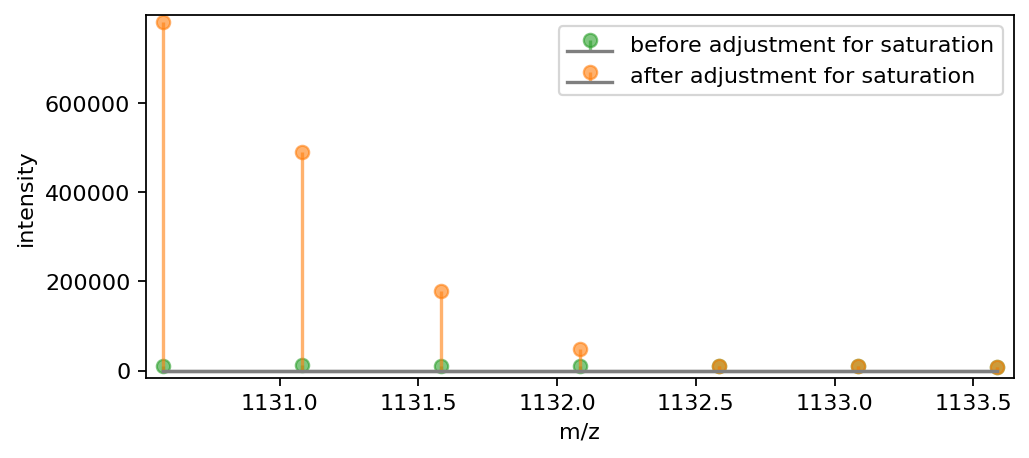

In [62]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz_centroid, isotope_intensities_df.summed_intensity, use_line_collection=True, label='before adjustment for saturation')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz_centroid, isotope_intensities_df.inferred_intensity, use_line_collection=True, label='after adjustment for saturation')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

plt.xlabel('m/z')
plt.ylabel('intensity')

f.set_figheight(3)
f.set_figwidth(7)
f.set_dpi(160)

plt.margins(0.02)
plt.legend(loc='best')
# plt.title('Isotopes before and after saturation adjustment')
plt.show()

#### plot the maximum inferred intensity

In [63]:
MAX_SUMMED_APEX_POINTS = 3 * SATURATION_INTENSITY
isotope_idx_not_in_saturation = 4

In [64]:
mz_lower = 300
mz_upper = 1700
charge_lower = 2
charge_upper = 4
isotope_not_saturated_indexes = [1,2,3,4,5,6]  # index of the first isotope not saturated

In [65]:
mono_mass_lower = calculate_monoisotopic_mass_from_mz(mz_lower, charge_lower)
mono_mass_upper = calculate_monoisotopic_mass_from_mz(mz_upper, charge_upper)
mono_mass_lower, mono_mass_upper

(597.985448, 6795.970896)

In [66]:
mono_mass_values = list(np.arange(start=mono_mass_lower, stop=mono_mass_upper))

In [67]:
isotopes_l = []
for isotope_idx_not_in_saturation in isotope_not_saturated_indexes:
    mono_intensities_l = []
    for monoisotopic_mass in mono_mass_values:
        isotope_intensities_l = list(np.full((NUMBER_OF_ISOTOPES,), MAX_SUMMED_APEX_POINTS))
        isotope_intensities_df = pd.DataFrame(isotope_intensities_l, columns=['summed_intensity'])
        isotope_intensities_df['inferred_intensity'] = isotope_intensities_df.summed_intensity
        isotope_intensities_df['inferred'] = False

        # using as a reference the most intense isotope that is not in saturation, derive the isotope intensities back to the monoisotopic
        Hpn = isotope_intensities_df.iloc[isotope_idx_not_in_saturation].summed_intensity
        for peak_number in reversed(range(1,isotope_idx_not_in_saturation+1)):
            phr = peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur=0)
            if phr is not None:
                Hpn_minus_1 = Hpn / phr
                isotope_intensities_df.at[peak_number-1, 'inferred_intensity'] = int(Hpn_minus_1)
                isotope_intensities_df.at[peak_number-1, 'inferred'] = True
                Hpn = Hpn_minus_1
            else:
                break
        monoisotope_intensity = int(isotope_intensities_df.iloc[0].inferred_intensity)  # the inferred saturation
        inferred = int(isotope_intensities_df.iloc[0].inferred)  # whether the monoisotope intensity was inferred
        mono_intensities_l.append((monoisotopic_mass,monoisotope_intensity,inferred))
    mono_intensities_df = pd.DataFrame(mono_intensities_l, columns=['monoisotopic_mass','inferred_mono_intensity','inferred'])
    isotopes_l.append(mono_intensities_df)
    

In [68]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

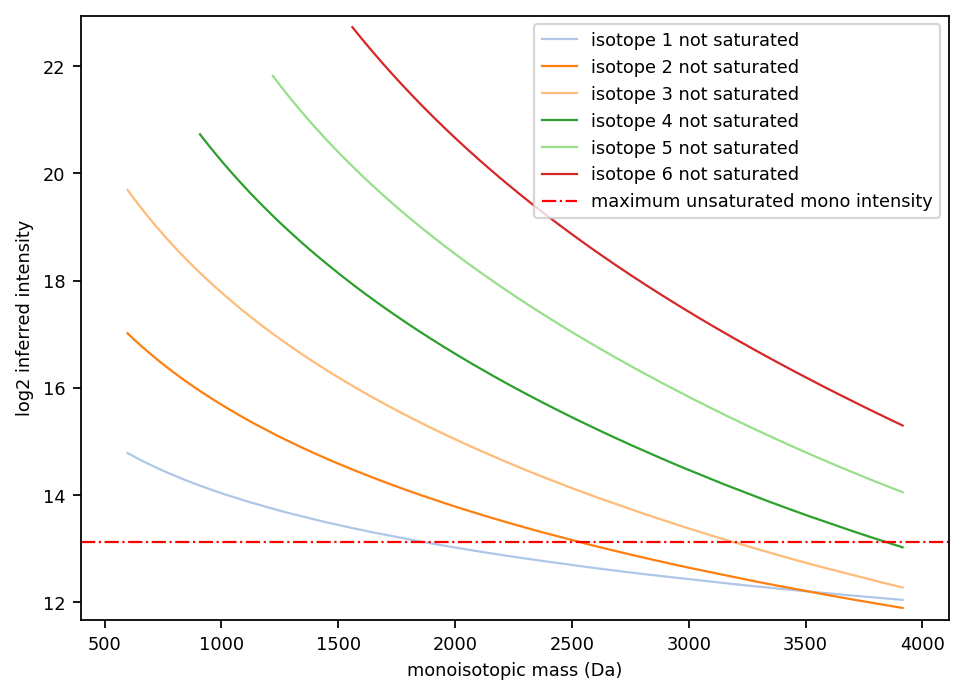

In [69]:
f, ax = plt.subplots()
f.set_figheight(5)
f.set_figwidth(7)
f.set_dpi(160)

plt.margins(x=0.06, y=0.02)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# title = 'maximum inferred intensity by monoisotopic mass'
# plt.title(title)

for idx in range(len(isotopes_l)):
    mono_intensities_df = isotopes_l[idx]
    plot_df = mono_intensities_df[mono_intensities_df.inferred == True]
    ax.plot(plot_df.monoisotopic_mass, np.log2(plot_df.inferred_mono_intensity), marker='', color=tableau20[idx+1 % len(tableau20)], linestyle='-', linewidth=1, ms=2, label='isotope {} not saturated'.format(idx+1))

plt.axhline(y=np.log2(MAX_SUMMED_APEX_POINTS), color='red', linestyle='-.', linewidth=1, label='maximum unsaturated mono intensity')
    
plt.legend(loc='best', fontsize=8)
plt.xlabel('monoisotopic mass (Da)', fontsize=8)
plt.ylabel('log2 inferred intensity', fontsize=8)

plt.show()

In [70]:
f.savefig('{}/paper-2-figure-9.tiff'.format(expanduser('~')), dpi=300, bbox_inches='tight')

In [71]:
monoisotopic_mass = 1170.563881

In [72]:
isotope_intensities_l = list(np.full((NUMBER_OF_ISOTOPES,), MAX_SUMMED_APEX_POINTS))
isotope_intensities_df = pd.DataFrame(isotope_intensities_l, columns=['summed_intensity'])
isotope_intensities_df['inferred_intensity'] = isotope_intensities_df.summed_intensity
isotope_intensities_df['inferred'] = False

# using as a reference the most intense isotope that is not in saturation, derive the isotope intensities back to the monoisotopic
Hpn = isotope_intensities_df.iloc[isotope_idx_not_in_saturation].summed_intensity
for peak_number in reversed(range(1,isotope_idx_not_in_saturation+1)):
    phr = peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur=0)
    if phr is not None:
        Hpn_minus_1 = Hpn / phr
        isotope_intensities_df.at[peak_number-1, 'inferred_intensity'] = int(Hpn_minus_1)
        isotope_intensities_df.at[peak_number-1, 'inferred'] = True
        Hpn = Hpn_minus_1
    else:
        break
monoisotope_intensity = int(isotope_intensities_df.iloc[0].inferred_intensity)  # the inferred saturation


In [73]:
monoisotope_intensity

9000